In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from time import time
from joblib import Memory
from joblib import parallel_backend
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import tempfile
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg
import os
import pywt
from util import IndexTracker
from util import par_feat_extract
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
rextract = 0
# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
            
    voxel_size = seg.header['pixdim'][0:3]
    voxel_sizes.append(voxel_size)
    segs.append(seg.get_fdata())

    qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
    qsms.append(qsm.get_fdata())
    
    case_list.append(filename)
    n_cases = len(segs)

label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
label_max = np.amax(seg.get_fdata())

F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 01
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 02
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 03
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 04
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 05
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 06
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 07
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 08
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 09
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 10
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 11
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 12
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 13
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 14
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 15
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 16
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 17
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 18
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 19
F:\dbs\stn-dbs\Cornell_anonymized\Anonymized - 20


In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('Phi_rr', 'wb') as fp:  
        pickle.dump(Phi, fp)


In [5]:
with open('Phi_rr', "rb") as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [7]:
 # SAS features 
pre_sas_on = np.array((8,2,12,17,11,22,2,5,13,4,11,7,7,16,9,8,9,13,10,11,6,5,17,12,11,21,9)).T
post_sas_on = np.array((21,3,19,13,13,14,11,12,23,12,4,6,11,28,17,8,21,8,17,11,9,20,17,19,15,19,11)).T
per_change = (pre_sas_on-post_sas_on)/pre_sas_on
pre_sas_off = np.array((13,2,9,20,21,12,3,27,22,29,30,17,13,27,9,8,16,31,10,2,8,5,17,14,8,12,8))
lct_change = (pre_sas_off-pre_sas_on)/pre_sas_off
# Apathy features
ap = np.array(('Y','N','Y','Y','Y','Y','N','Y','Y','Y','Y','Y','N','Y','Y','N','Y','Y','Y','Y','N','N','Y','N','Y','N','N')).T
ap[ap=='Y'] = 1 
ap[ap=='N'] = 0
bi_sas = ap

In [8]:
case_id = np.repeat(np.arange(1,n_cases+1),2)
ut = np.zeros((n_cases))
for j in np.arange(n_cases):
    # Extract numeric feature values
    n_ROIs = 2
    x_row = []
    x_row_t = []
    keys = []
    per_change_train = []
    for i in range(Phi.__len__()):
            featureVector = Phi[i]
            for key, value in six.iteritems(featureVector):
                if 'diagnostic' in key:
                    next
                else:
                    x_row.append(value)
                    keys.append(key)
            x_row.append(pre_sas_off[case_id[i]-1])
            x_row.append(pre_sas_on[case_id[i]-1])
            x_row.append(post_sas_on[case_id[i]-1])
            x_row.append(bi_sas[case_id[i]-1])
            keys.append('pre_sas_off')
            keys.append('pre_sas_on')
            keys.append('post_sas_off')
            keys.append('binary_sas')
            if np.mod(i,2):
                per_change_train.append(per_change[case_id[i]-1])

    X0 = np.array(x_row)
    X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
    X0_t = X[j,:]
    np.delete(X,j,0)
    # Normalize testing and training cases together
    #   Set with_mean=False to preserve data sparsity
    #   And with_std=False 
    #   However, need a significant number of samples to do this
    scaler = StandardScaler()
    X_all = np.vstack((X,X0_t))
    X_all_t = scaler.fit_transform(X_all)
    X_t = X_all_t[X.shape[0]:,:]
    X = X_all_t[:X.shape[0]]
    # Cross-validation for model selection
    cv = KFold(n_cases-2)
    # Identify most important features
    clf = RidgeCV(fit_intercept=True,cv=cv).fit(X,per_change_train)
    #clf = LassoCV(fit_intercept=True,cv=cv,max_iter=100000,alphas=((1e-3,1e-2,1e-1,1e1))).fit(X,per_change_train)
    # Feature selection
    sfm = SelectFromModel(clf,max_features=100,threshold=min(abs(clf.coef_[clf.coef_>0])))
    # Initialize pipeline
    clf_in = Pipeline([('LassoSelect',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))])
    # Select the optimal number of clusters with grid search
    Cs = ((1e-1,1,10))
    epsilons = ((0.01,0.1))
    clf_nsvr = GridSearchCV(clf_in,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error')
    clf_nsvr.fit(X,per_change_train)
    ut[j] = clf_nsvr.best_estimator_.predict(X_t)
    print('Predicted percentage change of',ut[j],'for case',j)
    print('True percentage change',per_change_train[j])
    print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))
    print(clf_nsvr.best_estimator_.get_params('SVR__C'))
    print(clf.alpha_)



c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -1.6147216997740932 for case 0
True percentage change -1.625
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.4077825767749134e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.4077825767749134e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimat

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.4899523262459231 for case 1
True percentage change -0.5
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.656829964432152e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.656829964432152e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator__

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.5935373169483305 for case 2
True percentage change -0.5833333333333334
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=8.050012542082541e-07)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=8.050012542082541e-07), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSele

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.22562866265028148 for case 3
True percentage change 0.23529411764705882
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=3.889608701750319e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=3.889608701750319e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSele

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.1715482465795195 for case 4
True percentage change -0.18181818181818182
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.1726444617960899e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.1726444617960899e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoS

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.35395924143317825 for case 5
True percentage change 0.36363636363636365
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=4.459989945864321e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=4.459989945864321e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSele

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -1.6815261004517934 for case 6
True percentage change -4.5
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3159318535874138e-06)), ('SVR', SVR(C=1, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3159318535874138e-06), 'SVR': SVR(C=1, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator__

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -1.3896537808349467 for case 7
True percentage change -1.4
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.0810617406871695e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.0810617406871695e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.7593298521802514 for case 8
True percentage change -0.7692307692307693
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.847818424456244e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.847818424456244e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSele

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -1.9896120417119387 for case 9
True percentage change -2.0
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=6.033003072862181e-09)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=6.033003072862181e-09), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator__

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.6263444794779132 for case 10
True percentage change 0.6363636363636364
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.3160519522361756e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.3160519522361756e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSel

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.1328684424358566 for case 11
True percentage change 0.14285714285714285
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.318555614246977e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.318555614246977e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSele

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.5613114989392738 for case 12
True percentage change -0.5714285714285714
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=7.2492473499693865e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=7.2492473499693865e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoS

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.7404730325081813 for case 13
True percentage change -0.75
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.57961499678143e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.57961499678143e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator__

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.8922260572770357 for case 14
True percentage change -0.8888888888888888
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=4.055071208619514e-07)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=4.055071208619514e-07), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSel

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.009456887997409735 for case 15
True percentage change 0.0
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=5.154652757548325e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=5.154652757548325e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -1.3236877090397374 for case 16
True percentage change -1.3333333333333333
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3661776893884813e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3661776893884813e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoS

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.3741791344538836 for case 17
True percentage change 0.38461538461538464
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=7.095635683569186e-07)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=7.095635683569186e-07), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSele

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.7098787773277313 for case 18
True percentage change -0.7
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.112174910449921e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.112174910449921e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator_

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.01039999792659474 for case 19
True percentage change 0.0
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=8.044088512180736e-07)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=8.044088512180736e-07), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator_

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.4901055622512034 for case 20
True percentage change -0.5
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.122555526755394e-05)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.122555526755394e-05), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator_

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -2.990044242421022 for case 21
True percentage change -3.0
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3648313730898268e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3648313730898268e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.010201796908424932 for case 22
True percentage change 0.0
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.227822534432051e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.227822534432051e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSelect__estimator_

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.5938199221711865 for case 23
True percentage change -0.5833333333333334
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=3.4260448157336296e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=3.4260448157336296e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoS

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.3540753217436202 for case 24
True percentage change -0.36363636363636365
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.152938412704761e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.152938412704761e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoSe

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of 0.08507924115728671 for case 25
True percentage change 0.09523809523809523
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3489107337513017e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=1.3489107337513017e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'LassoS

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

Predicted percentage change of -0.21230937814809625 for case 26
True percentage change -0.2222222222222222
{'memory': None, 'steps': [('LassoSelect', SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.9031797031911454e-06)), ('SVR', SVR(C=10, epsilon=0.01))], 'verbose': False, 'LassoSelect': SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                  cv=KFold(n_splits=25, random_state=None, shuffle=False)),
                max_features=100, threshold=2.9031797031911454e-06), 'SVR': SVR(C=10, epsilon=0.01), 'LassoSelect__estimator__alpha_per_target': False, 'LassoSelect__estimator__alphas': array([ 0.1,  1. , 10. ]), 'LassoSelect__estimator__cv': KFold(n_splits=25, random_state=None, shuffle=False), 'LassoSelect__estimator__fit_intercept': True, 'LassoSelect__estimator__gcv_mode': None, 'Lasso

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2

In [9]:
max(abs(clf.coef_))

0.008603524709304236

-0.8201665866045333


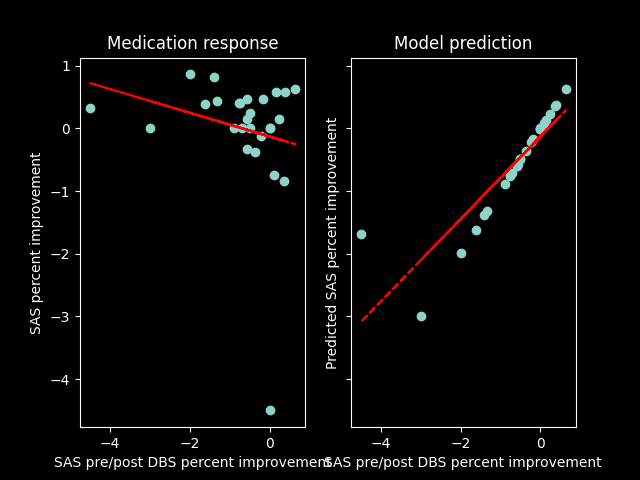

In [10]:

[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
ax[0].scatter(per_change,lct_change)
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
print(r2_score(per_change,p(per_change)))
ax[0].plot(per_change,p(per_change),"r--")
ax[0].set_title('Medication response')
ax[0].set_xlabel("SAS pre/post DBS percent improvement")
ax[0].set_ylabel("SAS percent improvement")
ax[1].scatter(per_change,ut)
z = np.polyfit(per_change,ut,1)
p = np.poly1d(z)
ax[1].plot(per_change,p(per_change),"r--")
ax[1].set_title('Model prediction')
ax[1].set_xlabel("SAS pre/post DBS percent improvement")
ax[1].set_ylabel("Predicted SAS percent improvement")
plt.show()


In [11]:
r2_score(per_change,p(per_change))

0.8735332226932867

In [12]:
feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
for k in range(feats.__len__()-1):
    if feats[k] == True:
        print(keys[k])



original_glcm_ClusterProminence
original_glcm_MaximumProbability
original_glszm_LargeAreaHighGrayLevelEmphasis
gradient_glszm_LargeAreaEmphasis
gradient_glszm_LargeAreaHighGrayLevelEmphasis
gradient_glszm_LowGrayLevelZoneEmphasis
gradient_glszm_SmallAreaLowGrayLevelEmphasis
lbp-3D-m1_firstorder_Kurtosis
lbp-3D-m1_firstorder_Minimum
lbp-3D-m2_firstorder_10Percentile
lbp-3D-m2_firstorder_Minimum
lbp-3D-m2_firstorder_Range
lbp-3D-k_firstorder_Kurtosis
lbp-3D-k_glszm_GrayLevelNonUniformity
lbp-3D-k_glszm_GrayLevelNonUniformityNormalized
lbp-3D-k_glszm_GrayLevelVariance
lbp-3D-k_glszm_HighGrayLevelZoneEmphasis
lbp-3D-k_glszm_LargeAreaEmphasis
lbp-3D-k_glszm_LargeAreaHighGrayLevelEmphasis
lbp-3D-k_glszm_LargeAreaLowGrayLevelEmphasis
lbp-3D-k_glszm_LowGrayLevelZoneEmphasis
lbp-3D-k_glszm_SmallAreaEmphasis
lbp-3D-k_glszm_SmallAreaHighGrayLevelEmphasis
lbp-3D-k_glszm_SmallAreaLowGrayLevelEmphasis
logarithm_gldm_LargeDependenceHighGrayLevelEmphasis
logarithm_glszm_LargeAreaHighGrayLevelEmphasis


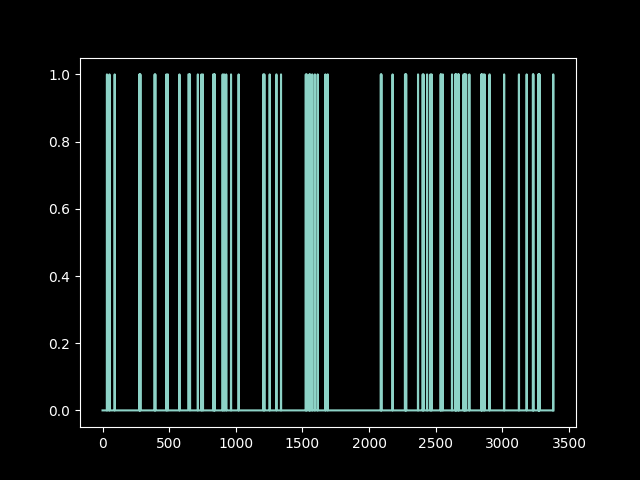

In [13]:
fig,ax = plt.subplots(1,1)
plt.plot(feats)
plt.show()

In [14]:
clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape

(25, 100)

In [15]:
np.array(clf_nsvr.best_estimator_.predict(X))

array([-1.61497259, -0.49020827, -0.59322509,  0.22489569, -0.19201573,
        0.35390839, -4.48943466, -1.39003692, -0.75921147, -1.98997462,
        0.6260721 ,  0.13274748, -0.58147355, -0.75051979, -0.89875579,
       -0.00989484, -1.32328434,  0.37461201, -0.70999053, -0.01004772,
       -0.4899726 , -2.99001487,  0.00799697, -0.5929577 , -0.35368333,
        0.085008  , -0.21230938])

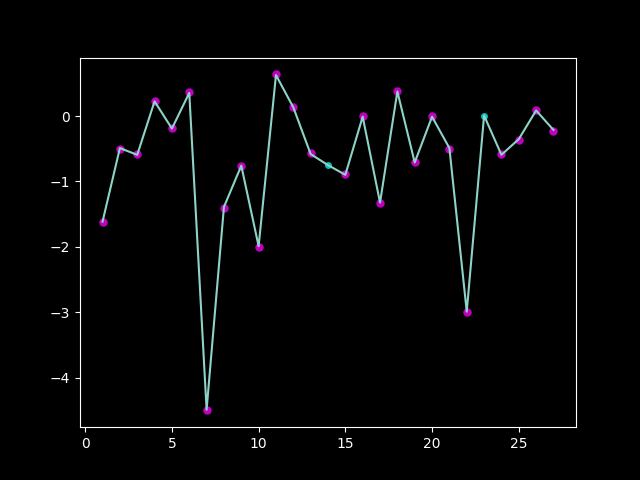

In [16]:
cases = np.linspace(1,n_cases,n_cases)
fig,ax = plt.subplots(1,1)
sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
# Plot remaining data
plt.scatter(cases, per_change, label="data", zorder=2, c="c", edgecolors=(0, 0, 0))
# Plot support vectors
plt.scatter(
    cases[sv_ind],
    per_change[sv_ind],
    s=50,
    c="m",
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0))


plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X))),
plt.style.use('dark_background')
plt.show()

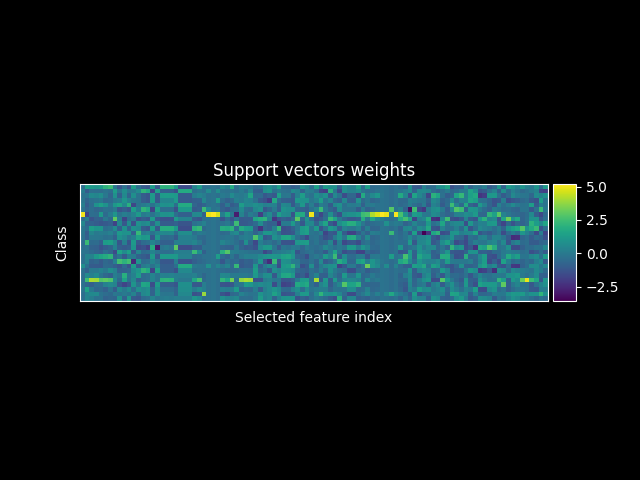

In [17]:
X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
fig,ax = plt.subplots(1,1)
im_svr = plt.imshow(X_SVR)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vectors weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svr,cax=cax,orientation='vertical')


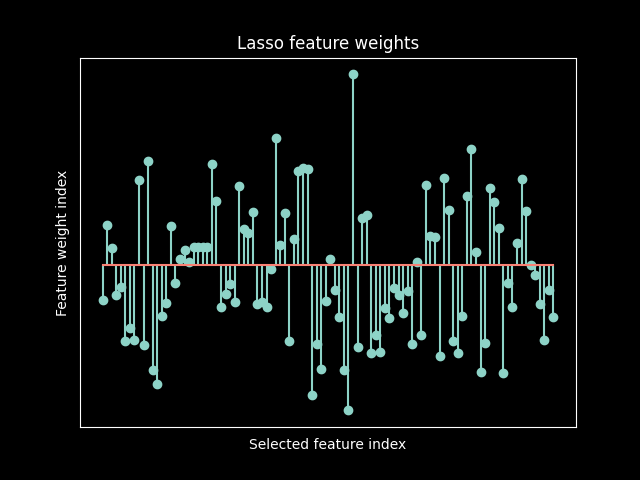

In [18]:
X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)
fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso.ravel())
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');